In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix


plt.style.use('fivethirtyeight')

In [2]:
ROOT_DIR = 'MNIST'

train_data = datasets.MNIST(
    root = ROOT_DIR,
    train = True,
    transform = transforms.ToTensor(),
    target_transform = None,
    download = True   

)

test_data = datasets.MNIST(
    root = ROOT_DIR,
    train = False,
    transform = transforms.ToTensor(),
    target_transform = None,
    download = True   

)

Files already downloaded
Files already downloaded


In [3]:
train_data.train_data.dtype

torch.uint8

In [4]:
test_data.test_data.dtype

torch.uint8

In [5]:
train_data.train_labels

tensor([5, 0, 4,  ..., 5, 6, 8])

<AxesSubplot:>

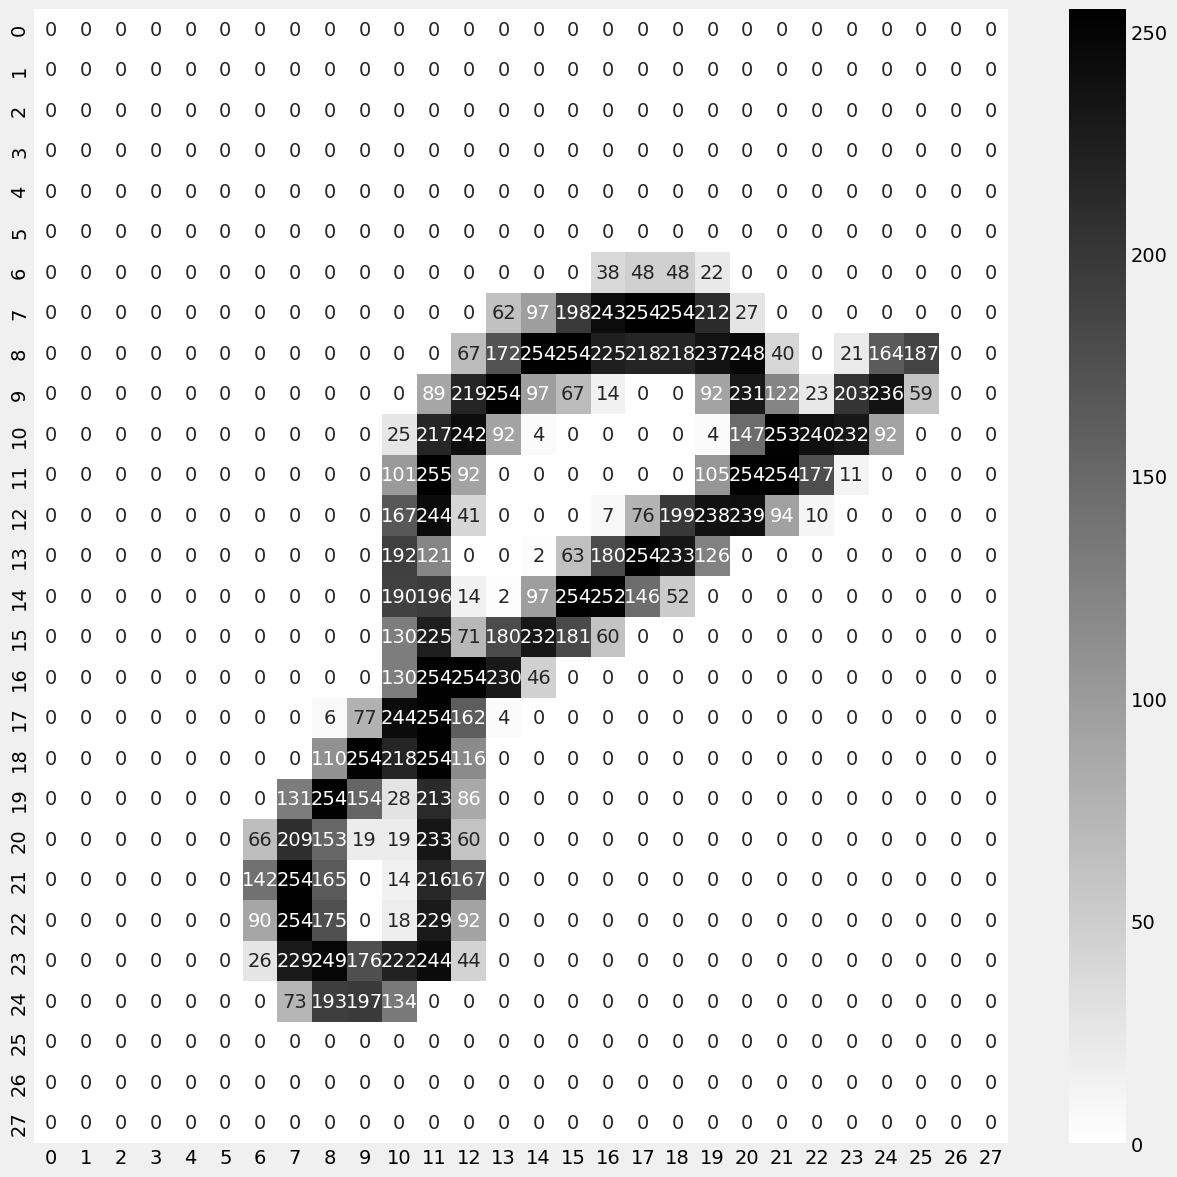

In [6]:
plt.figure(figsize=(14,14))
sns.heatmap(train_data.train_data[-1],cmap='binary',fmt='d',annot=True)

In [7]:
train_data.train_data.shape

torch.Size([60000, 28, 28])

In [8]:
BATCH=128

train_data_loader=DataLoader(
                    dataset=train_data,
                    batch_size=BATCH,
                    shuffle=True,
                    
)


test_data_loader=DataLoader(
                    dataset=test_data,
                    batch_size=BATCH,
                    
)




In [9]:
for x in train_data_loader:
    print(x[0].shape)
    break

torch.Size([128, 1, 28, 28])


In [10]:
for batch, data in enumerate(train_data_loader):
    if batch==467:
        print(data[0].shape)
        


torch.Size([128, 1, 28, 28])


In [11]:
DEVICE='cuda' if torch.cuda.is_available() else "cpu"

In [12]:
DEVICE

'cuda'

In [13]:
class NeuralNetwork(nn.Module):
    def __init__(self,in_,out_):
        super().__init__()
        self.layers=nn.Sequential(
            nn.Linear(in_,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,out_)
        )
    def forward(self,x):
        return self.layers(x)
    

In [14]:
model=NeuralNetwork(784,10)
model.to(DEVICE)

model

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [15]:
CE_loss=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters())

In [28]:
EPOCHS = 10
loss_ = list()
acc_ = list()


for epoch in range(EPOCHS):
    print(f"Epoch: {epoch + 1}/{EPOCHS}")
    for batch, data in enumerate(train_data_loader):
        x = data[0].to(DEVICE)
        y = data[1].to(DEVICE)
        
        optimizer.zero_grad()
        
        y_pred = model(x.reshape(-1, 784))
        #print("y_pred",y_pred.shape)
        
        loss = CE_loss(y_pred, y)
        
        
        loss_.append(loss)
        loss.backward()
        optimizer.step()
        
        #print(torch.mean((torch.argmax(y_pred, 1) == y).float()))
        accuracy = torch.mean((torch.argmax(y_pred, 1) == y).float())
        acc_.append(accuracy)
        
        if batch%100 == 0:
            print(f"   Batch: {batch}, Loss: {loss.item():.4f} Accuracy {accuracy:.4f}")


Epoch: 1/10
   Batch: 0, Loss: 0.0006 Accuracy 1.0000
   Batch: 100, Loss: 0.0008 Accuracy 1.0000
   Batch: 200, Loss: 0.0025 Accuracy 1.0000
   Batch: 300, Loss: 0.0070 Accuracy 0.9922
   Batch: 400, Loss: 0.0075 Accuracy 0.9922
Epoch: 2/10
   Batch: 0, Loss: 0.0036 Accuracy 1.0000
   Batch: 100, Loss: 0.0002 Accuracy 1.0000
   Batch: 200, Loss: 0.0005 Accuracy 1.0000
   Batch: 300, Loss: 0.0001 Accuracy 1.0000
   Batch: 400, Loss: 0.0003 Accuracy 1.0000
Epoch: 3/10
   Batch: 0, Loss: 0.0001 Accuracy 1.0000
   Batch: 100, Loss: 0.0012 Accuracy 1.0000
   Batch: 200, Loss: 0.0005 Accuracy 1.0000
   Batch: 300, Loss: 0.0012 Accuracy 1.0000
   Batch: 400, Loss: 0.0024 Accuracy 1.0000
Epoch: 4/10
   Batch: 0, Loss: 0.0002 Accuracy 1.0000
   Batch: 100, Loss: 0.0051 Accuracy 1.0000
   Batch: 200, Loss: 0.0001 Accuracy 1.0000
   Batch: 300, Loss: 0.0000 Accuracy 1.0000
   Batch: 400, Loss: 0.0022 Accuracy 1.0000
Epoch: 5/10
   Batch: 0, Loss: 0.0000 Accuracy 1.0000
   Batch: 100, Loss: 0.000

In [27]:
a=torch.tensor([[1,2,3],
               [2,5,7],
               [8,9,34]])

torch.argmax(a,1)

tensor([2, 2, 2])

In [31]:
# plot the Train acc and loss
# plt.figure(figsize=(14,14))

print(loss_)
acc_
pd.DataFrame(data={'loss': loss_, "Accuracy": acc_}).plot(figsize=(10,5))

[tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.0072, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.0009, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.0029, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.0309, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.0024, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.0293, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.0049, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(5.6578e-05, devi

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
# testing over the test data

test_loss = 0
test_acc = 0

with torch.no_grad():
    for batch, data in enumerate(test_data_loader):
        x = data[0].to(DEVICE)
        y = data[1].to(DEVICE)        
        
        y_pred = model(x.reshape(-1, 784))
        loss = CE_loss(y_pred, y)
        
        test_loss += loss.item()
        test_acc += torch.mean((torch.argmax(y_pred, 1) == y).float()).item()

In [ ]:
print(f"test loss: {test_loss/batch:.4f}, test accuracy: {test_acc/batch:.4f}")

In [ ]:
pred = np.array([])
target = np.array([])

with torch.no_grad():
    for batch, data in enumerate(test_data_loader):
        x = data[0].to(DEVICE)
        y = data[1].to(DEVICE)        
        
        y_pred = model(x.reshape(-1, 784))
        loss = CE_loss(y_pred, y)
        
        pred = np.concatenate((pred, torch.argmax(y_pred, 1).cpu().numpy()))
        target = np.concatenate((target, y.cpu().numpy()))   

In [ ]:
cm = confusion_matrix(target, pred)


In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d')